## LIBRERIAS


In [1]:
import pandas as pd
import numpy as np
from unicodedata import normalize
from sklearn.model_selection import RandomizedSearchCV
import plotly.graph_objs as go #Graficos
import plotly.express as px
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt ### gráficos
from sklearn import linear_model ## para regresión lineal
from sklearn import tree ###para ajustar arboles de decisión
from sklearn import svm
from sklearn.ensemble import RandomForestRegressor ##Ensamble con bagging
from sklearn.ensemble import GradientBoostingRegressor ###Ensamble boosting
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import sqlite3 as sql
import datetime as datetime
import seaborn as sns
from dateutil.relativedelta import relativedelta



In [2]:
conn = sql.connect(r'D:\Users\USUARIO\Downloads\BD_insurance2019dataset.db')

# Creación del cursor
cursor = conn.cursor()

# Ejecución de la consulta SQL para obtener la lista de tablas
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")

# Almacenamiento de los resultados en una lista
tables = cursor.fetchall()

# Impresión de la lista de tablas
print(tables)

[('reclamaciones',), ('diagnosticos',), ('regional',), ('genero',), ('sociodemograficas',), ('utilizaciones',)]


In [3]:
# Se extrae toda la información de cada uno de los datasets
reclamaciones=pd.read_sql("SELECT * FROM reclamaciones; ",conn)
diagnosticos=pd.read_sql("SELECT * FROM diagnosticos; ",conn)
regional=pd.read_sql("SELECT * FROM regional; ",conn)
genero=pd.read_sql("SELECT * FROM genero; ",conn)
sociodemograficas=pd.read_sql("SELECT * FROM sociodemograficas; ",conn)
utilizaciones=pd.read_sql("SELECT * FROM utilizaciones; ",conn)

## TRANSFORMACIÓN Y LIMPIEZA DE LAS BASES

In [4]:
#Se cambian nombres de algunas columnas y se transforman a otro tipo
reclamaciones=reclamaciones.rename(columns={"Reclamacion_Id":"Reclamacion_codigo"})
reclamaciones['Reclamacion_codigo']=reclamaciones['Reclamacion_codigo'].astype("int")
reclamaciones

,Reclamacion_codigo,Reclamacion_Desc
0,1,ATENCION DEL PARTO
1,2,ATENCION INTEGRAL DE SALUD MENTAL
2,3,CIRUGIA AMBULATORIA POR ACCIDENTE
3,4,CIRUGIA AMBULATORIA POR ENFERMEDAD
4,5,CIRUGIA AMBULATORIA POR ENFERMEDAD CONGENITA
5,6,COBERTURA PROGRAMA PALIATIVOS
6,7,CONCILIACION
7,8,CONSULTA DE URGENCIAS
8,9,CONSULTA EXTERNA
9,10,CONSULTAS PRENATALES


In [6]:

diagnosticos['Diagnostico_Codigo'].replace("-1","0", inplace=True)
diagnosticos['Diagnostico_Codigo'].replace("9","0", inplace=True)
diagnosticos=diagnosticos.drop([0,1], axis=0).reset_index().drop(columns='index')
diagnosticos.loc[diagnosticos['Diagnostico_Codigo'] == "A09X"]


,Diagnostico_Codigo,Diagnostico_Desc
9,A09X,DIARREA Y GASTROENTERITIS DE PRESUNTO ORIGEN I...


In [6]:
regional=regional.rename(columns={"Regional_id":"Regional_codigo"})
regional['Regional_codigo']=regional['Regional_codigo'].astype('object')
regional

,Regional_codigo,Regional_Desc
0,1,REGIONAL ANTIOQUIA
1,2,REGIONAL CENTRO
2,3,REGIONAL NORTE
3,4,REGIONAL OCCIDENTE
4,5,REGIONAL EJE CAFETERO
5,6,Sin Información


In [7]:
genero

,Sexo_Cd,Sexo_desc
0,M,Masculino
1,F,Femenino
2,-1,Sin Informacion


In [8]:
sociodemograficas['FechaNacimiento']=sociodemograficas['FechaNacimiento'].apply(lambda x: datetime.datetime(1899, 12, 30) + datetime.timedelta(days=x))
sociodemograficas

,Afiliado_Id,Sexo_codigo,FechaNacimiento,Regional_codigo,CANCER,EPOC,DIABETES,HIPERTENSION,ENF_CARDIOVASCULAR
0,738288,M,1976-11-08,1,0,0,0,0,0
1,738294,M,1964-01-16,2,0,0,0,0,0
2,738303,F,1974-05-28,3,0,0,0,0,0
3,738318,M,1941-03-18,2,1,0,1,1,0
4,738323,F,1928-08-07,2,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...
218200,59559606,F,2004-06-26,2,0,0,0,0,0
218201,59564764,F,2005-03-18,2,0,0,0,0,0
218202,59565065,F,2005-03-14,2,0,0,0,0,0
218203,59570753,M,1976-03-20,4,0,0,0,0,0


In [9]:
utilizaciones['Reclamacion_codigo']=utilizaciones['Reclamacion_codigo'].astype("int")
utilizaciones['Diagnostico_Codigo'].replace("9","0", inplace=True)
utilizaciones['Diagnostico_Codigo'].replace("-1","0", inplace=True)
utilizaciones


,Fecha_Reclamacion,Afiliado_Id,Reclamacion_codigo,Diagnostico_Codigo,Cantidad,Precio
0,23/10/2019,22914637,12,M45X,1.0,1056639.96
1,26/11/2019,58412744,9,0,1.0,139772.80
2,23/10/2019,5070923,16,0,1.0,320166.76
3,27/11/2019,5769950,13,0,1.0,21204.00
4,8/11/2019,24022833,12,K589,1.0,60636.00
...,...,...,...,...,...,...
395863,14/11/2019,4351189,16,0,15.0,251820.44
395864,7/9/2019,44677250,9,0,1.0,67208.00
395865,25/10/2019,19220270,13,0,10.0,475726.00
395866,11/12/2019,25627716,12,0,2.0,568788.00


In [10]:
# Se integran los diferentes datasets en un solo dataset
Seguro_salud=pd.merge(utilizaciones,sociodemograficas,on="Afiliado_Id", how="left" )
Seguro_salud=pd.merge(Seguro_salud,regional,on="Regional_codigo", how="left" )
Seguro_salud=pd.merge(Seguro_salud,diagnosticos,on="Diagnostico_Codigo", how="left" )
Seguro_salud=pd.merge(Seguro_salud,reclamaciones,on="Reclamacion_codigo", how="left" )
Seguro_salud



,Fecha_Reclamacion,Afiliado_Id,Reclamacion_codigo,Diagnostico_Codigo,Cantidad,Precio,Sexo_codigo,FechaNacimiento,Regional_codigo,CANCER,EPOC,DIABETES,HIPERTENSION,ENF_CARDIOVASCULAR,Regional_Desc,Diagnostico_Desc,Reclamacion_Desc
0,23/10/2019,22914637,12,M45X,1.0,1056639.96,M,1991-04-17,5,0.0,0.0,0.0,0.0,0.0,REGIONAL EJE CAFETERO,ESPONDILITIS ANQUILOSANTE,EXAMENES DE DIAGNOSTICO
1,26/11/2019,58412744,9,0,1.0,139772.80,F,2004-04-24,2,0.0,0.0,0.0,0.0,0.0,REGIONAL CENTRO,DIAGNÓSTICO PENDIENTE,CONSULTA EXTERNA
2,23/10/2019,5070923,16,0,1.0,320166.76,F,1974-05-05,2,0.0,0.0,0.0,0.0,0.0,REGIONAL CENTRO,DIAGNÓSTICO PENDIENTE,LABORATORIO CLINICO
3,27/11/2019,5769950,13,0,1.0,21204.00,F,1928-09-11,2,0.0,0.0,0.0,0.0,0.0,REGIONAL CENTRO,DIAGNÓSTICO PENDIENTE,FISIOTERAPIA ILIMITADA
4,8/11/2019,24022833,12,K589,1.0,60636.00,M,1990-07-19,2,0.0,0.0,0.0,0.0,0.0,REGIONAL CENTRO,SÍNDROME DEL COLON IRRITABLE SIN DIARREA,EXAMENES DE DIAGNOSTICO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395863,14/11/2019,4351189,16,0,15.0,251820.44,F,1951-10-22,5,0.0,0.0,0.0,1.0,0.0,REGIONAL EJE CAFETERO,DIAGNÓSTICO PENDIENTE,LABORATORIO CLINICO
395864,7/9/2019,44677250,9,0,1.0,67208.00,F,1999-03-28,1,0.0,0.0,0.0,0.0,0.0,REGIONAL ANTIOQUIA,DIAGNÓSTICO PENDIENTE,CONSULTA EXTERNA
395865,25/10/2019,19220270,13,0,10.0,475726.00,F,1980-01-29,1,0.0,0.0,0.0,0.0,0.0,REGIONAL ANTIOQUIA,DIAGNÓSTICO PENDIENTE,FISIOTERAPIA ILIMITADA
395866,11/12/2019,25627716,12,0,2.0,568788.00,F,1981-03-07,2,0.0,0.0,0.0,0.0,0.0,REGIONAL CENTRO,DIAGNÓSTICO PENDIENTE,EXAMENES DE DIAGNOSTICO


In [11]:
# A partir de la columna fecha de nacimiento se calcula la edad de la persona
Seguro_salud['FechaNacimiento']=2019-Seguro_salud.FechaNacimiento.dt.year
Seguro_salud


,Fecha_Reclamacion,Afiliado_Id,Reclamacion_codigo,Diagnostico_Codigo,Cantidad,Precio,Sexo_codigo,FechaNacimiento,Regional_codigo,CANCER,EPOC,DIABETES,HIPERTENSION,ENF_CARDIOVASCULAR,Regional_Desc,Diagnostico_Desc,Reclamacion_Desc
0,23/10/2019,22914637,12,M45X,1.0,1056639.96,M,28.0,5,0.0,0.0,0.0,0.0,0.0,REGIONAL EJE CAFETERO,ESPONDILITIS ANQUILOSANTE,EXAMENES DE DIAGNOSTICO
1,26/11/2019,58412744,9,0,1.0,139772.80,F,15.0,2,0.0,0.0,0.0,0.0,0.0,REGIONAL CENTRO,DIAGNÓSTICO PENDIENTE,CONSULTA EXTERNA
2,23/10/2019,5070923,16,0,1.0,320166.76,F,45.0,2,0.0,0.0,0.0,0.0,0.0,REGIONAL CENTRO,DIAGNÓSTICO PENDIENTE,LABORATORIO CLINICO
3,27/11/2019,5769950,13,0,1.0,21204.00,F,91.0,2,0.0,0.0,0.0,0.0,0.0,REGIONAL CENTRO,DIAGNÓSTICO PENDIENTE,FISIOTERAPIA ILIMITADA
4,8/11/2019,24022833,12,K589,1.0,60636.00,M,29.0,2,0.0,0.0,0.0,0.0,0.0,REGIONAL CENTRO,SÍNDROME DEL COLON IRRITABLE SIN DIARREA,EXAMENES DE DIAGNOSTICO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395863,14/11/2019,4351189,16,0,15.0,251820.44,F,68.0,5,0.0,0.0,0.0,1.0,0.0,REGIONAL EJE CAFETERO,DIAGNÓSTICO PENDIENTE,LABORATORIO CLINICO
395864,7/9/2019,44677250,9,0,1.0,67208.00,F,20.0,1,0.0,0.0,0.0,0.0,0.0,REGIONAL ANTIOQUIA,DIAGNÓSTICO PENDIENTE,CONSULTA EXTERNA
395865,25/10/2019,19220270,13,0,10.0,475726.00,F,39.0,1,0.0,0.0,0.0,0.0,0.0,REGIONAL ANTIOQUIA,DIAGNÓSTICO PENDIENTE,FISIOTERAPIA ILIMITADA
395866,11/12/2019,25627716,12,0,2.0,568788.00,F,38.0,2,0.0,0.0,0.0,0.0,0.0,REGIONAL CENTRO,DIAGNÓSTICO PENDIENTE,EXAMENES DE DIAGNOSTICO


In [12]:
Seguro_salud=Seguro_salud.rename(columns={"FechaNacimiento":"Edad"})
Seguro_salud

,Fecha_Reclamacion,Afiliado_Id,Reclamacion_codigo,Diagnostico_Codigo,Cantidad,Precio,Sexo_codigo,Edad,Regional_codigo,CANCER,EPOC,DIABETES,HIPERTENSION,ENF_CARDIOVASCULAR,Regional_Desc,Diagnostico_Desc,Reclamacion_Desc
0,23/10/2019,22914637,12,M45X,1.0,1056639.96,M,28.0,5,0.0,0.0,0.0,0.0,0.0,REGIONAL EJE CAFETERO,ESPONDILITIS ANQUILOSANTE,EXAMENES DE DIAGNOSTICO
1,26/11/2019,58412744,9,0,1.0,139772.80,F,15.0,2,0.0,0.0,0.0,0.0,0.0,REGIONAL CENTRO,DIAGNÓSTICO PENDIENTE,CONSULTA EXTERNA
2,23/10/2019,5070923,16,0,1.0,320166.76,F,45.0,2,0.0,0.0,0.0,0.0,0.0,REGIONAL CENTRO,DIAGNÓSTICO PENDIENTE,LABORATORIO CLINICO
3,27/11/2019,5769950,13,0,1.0,21204.00,F,91.0,2,0.0,0.0,0.0,0.0,0.0,REGIONAL CENTRO,DIAGNÓSTICO PENDIENTE,FISIOTERAPIA ILIMITADA
4,8/11/2019,24022833,12,K589,1.0,60636.00,M,29.0,2,0.0,0.0,0.0,0.0,0.0,REGIONAL CENTRO,SÍNDROME DEL COLON IRRITABLE SIN DIARREA,EXAMENES DE DIAGNOSTICO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395863,14/11/2019,4351189,16,0,15.0,251820.44,F,68.0,5,0.0,0.0,0.0,1.0,0.0,REGIONAL EJE CAFETERO,DIAGNÓSTICO PENDIENTE,LABORATORIO CLINICO
395864,7/9/2019,44677250,9,0,1.0,67208.00,F,20.0,1,0.0,0.0,0.0,0.0,0.0,REGIONAL ANTIOQUIA,DIAGNÓSTICO PENDIENTE,CONSULTA EXTERNA
395865,25/10/2019,19220270,13,0,10.0,475726.00,F,39.0,1,0.0,0.0,0.0,0.0,0.0,REGIONAL ANTIOQUIA,DIAGNÓSTICO PENDIENTE,FISIOTERAPIA ILIMITADA
395866,11/12/2019,25627716,12,0,2.0,568788.00,F,38.0,2,0.0,0.0,0.0,0.0,0.0,REGIONAL CENTRO,DIAGNÓSTICO PENDIENTE,EXAMENES DE DIAGNOSTICO


In [13]:
Seguro_salud['Regional_Desc']=Seguro_salud['Regional_Desc'].replace("Sin Información","Region no especificada")
Seguro_salud


,Fecha_Reclamacion,Afiliado_Id,Reclamacion_codigo,Diagnostico_Codigo,Cantidad,Precio,Sexo_codigo,Edad,Regional_codigo,CANCER,EPOC,DIABETES,HIPERTENSION,ENF_CARDIOVASCULAR,Regional_Desc,Diagnostico_Desc,Reclamacion_Desc
0,23/10/2019,22914637,12,M45X,1.0,1056639.96,M,28.0,5,0.0,0.0,0.0,0.0,0.0,REGIONAL EJE CAFETERO,ESPONDILITIS ANQUILOSANTE,EXAMENES DE DIAGNOSTICO
1,26/11/2019,58412744,9,0,1.0,139772.80,F,15.0,2,0.0,0.0,0.0,0.0,0.0,REGIONAL CENTRO,DIAGNÓSTICO PENDIENTE,CONSULTA EXTERNA
2,23/10/2019,5070923,16,0,1.0,320166.76,F,45.0,2,0.0,0.0,0.0,0.0,0.0,REGIONAL CENTRO,DIAGNÓSTICO PENDIENTE,LABORATORIO CLINICO
3,27/11/2019,5769950,13,0,1.0,21204.00,F,91.0,2,0.0,0.0,0.0,0.0,0.0,REGIONAL CENTRO,DIAGNÓSTICO PENDIENTE,FISIOTERAPIA ILIMITADA
4,8/11/2019,24022833,12,K589,1.0,60636.00,M,29.0,2,0.0,0.0,0.0,0.0,0.0,REGIONAL CENTRO,SÍNDROME DEL COLON IRRITABLE SIN DIARREA,EXAMENES DE DIAGNOSTICO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395863,14/11/2019,4351189,16,0,15.0,251820.44,F,68.0,5,0.0,0.0,0.0,1.0,0.0,REGIONAL EJE CAFETERO,DIAGNÓSTICO PENDIENTE,LABORATORIO CLINICO
395864,7/9/2019,44677250,9,0,1.0,67208.00,F,20.0,1,0.0,0.0,0.0,0.0,0.0,REGIONAL ANTIOQUIA,DIAGNÓSTICO PENDIENTE,CONSULTA EXTERNA
395865,25/10/2019,19220270,13,0,10.0,475726.00,F,39.0,1,0.0,0.0,0.0,0.0,0.0,REGIONAL ANTIOQUIA,DIAGNÓSTICO PENDIENTE,FISIOTERAPIA ILIMITADA
395866,11/12/2019,25627716,12,0,2.0,568788.00,F,38.0,2,0.0,0.0,0.0,0.0,0.0,REGIONAL CENTRO,DIAGNÓSTICO PENDIENTE,EXAMENES DE DIAGNOSTICO


In [14]:
Seguro_salud['Fecha_Reclamacion'] = pd.to_datetime(Seguro_salud['Fecha_Reclamacion'])
Seguro_salud

,Fecha_Reclamacion,Afiliado_Id,Reclamacion_codigo,Diagnostico_Codigo,Cantidad,Precio,Sexo_codigo,Edad,Regional_codigo,CANCER,EPOC,DIABETES,HIPERTENSION,ENF_CARDIOVASCULAR,Regional_Desc,Diagnostico_Desc,Reclamacion_Desc
0,2019-10-23,22914637,12,M45X,1.0,1056639.96,M,28.0,5,0.0,0.0,0.0,0.0,0.0,REGIONAL EJE CAFETERO,ESPONDILITIS ANQUILOSANTE,EXAMENES DE DIAGNOSTICO
1,2019-11-26,58412744,9,0,1.0,139772.80,F,15.0,2,0.0,0.0,0.0,0.0,0.0,REGIONAL CENTRO,DIAGNÓSTICO PENDIENTE,CONSULTA EXTERNA
2,2019-10-23,5070923,16,0,1.0,320166.76,F,45.0,2,0.0,0.0,0.0,0.0,0.0,REGIONAL CENTRO,DIAGNÓSTICO PENDIENTE,LABORATORIO CLINICO
3,2019-11-27,5769950,13,0,1.0,21204.00,F,91.0,2,0.0,0.0,0.0,0.0,0.0,REGIONAL CENTRO,DIAGNÓSTICO PENDIENTE,FISIOTERAPIA ILIMITADA
4,2019-08-11,24022833,12,K589,1.0,60636.00,M,29.0,2,0.0,0.0,0.0,0.0,0.0,REGIONAL CENTRO,SÍNDROME DEL COLON IRRITABLE SIN DIARREA,EXAMENES DE DIAGNOSTICO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395863,2019-11-14,4351189,16,0,15.0,251820.44,F,68.0,5,0.0,0.0,0.0,1.0,0.0,REGIONAL EJE CAFETERO,DIAGNÓSTICO PENDIENTE,LABORATORIO CLINICO
395864,2019-07-09,44677250,9,0,1.0,67208.00,F,20.0,1,0.0,0.0,0.0,0.0,0.0,REGIONAL ANTIOQUIA,DIAGNÓSTICO PENDIENTE,CONSULTA EXTERNA
395865,2019-10-25,19220270,13,0,10.0,475726.00,F,39.0,1,0.0,0.0,0.0,0.0,0.0,REGIONAL ANTIOQUIA,DIAGNÓSTICO PENDIENTE,FISIOTERAPIA ILIMITADA
395866,2019-11-12,25627716,12,0,2.0,568788.00,F,38.0,2,0.0,0.0,0.0,0.0,0.0,REGIONAL CENTRO,DIAGNÓSTICO PENDIENTE,EXAMENES DE DIAGNOSTICO


In [15]:
Seguro_salud['Sexo_codigo']=Seguro_salud['Sexo_codigo'].replace('-1',"NN")
Seguro_salud.isnull().sum()

Fecha_Reclamacion        0
Afiliado_Id              0
Reclamacion_codigo       0
Diagnostico_Codigo       0
Cantidad                 0
Precio                   0
Sexo_codigo           4876
Edad                  4876
Regional_codigo       4876
CANCER                4876
EPOC                  4876
DIABETES              4876
HIPERTENSION          4876
ENF_CARDIOVASCULAR    4876
Regional_Desc         4876
Diagnostico_Desc         0
Reclamacion_Desc         0
dtype: int64

In [16]:
Seguro_salud['Reclamacion_codigo']=Seguro_salud['Reclamacion_codigo'].astype("int")
Seguro_salud=Seguro_salud.dropna()
Seguro_salud

,Fecha_Reclamacion,Afiliado_Id,Reclamacion_codigo,Diagnostico_Codigo,Cantidad,Precio,Sexo_codigo,Edad,Regional_codigo,CANCER,EPOC,DIABETES,HIPERTENSION,ENF_CARDIOVASCULAR,Regional_Desc,Diagnostico_Desc,Reclamacion_Desc
0,2019-10-23,22914637,12,M45X,1.0,1056639.96,M,28.0,5,0.0,0.0,0.0,0.0,0.0,REGIONAL EJE CAFETERO,ESPONDILITIS ANQUILOSANTE,EXAMENES DE DIAGNOSTICO
1,2019-11-26,58412744,9,0,1.0,139772.80,F,15.0,2,0.0,0.0,0.0,0.0,0.0,REGIONAL CENTRO,DIAGNÓSTICO PENDIENTE,CONSULTA EXTERNA
2,2019-10-23,5070923,16,0,1.0,320166.76,F,45.0,2,0.0,0.0,0.0,0.0,0.0,REGIONAL CENTRO,DIAGNÓSTICO PENDIENTE,LABORATORIO CLINICO
3,2019-11-27,5769950,13,0,1.0,21204.00,F,91.0,2,0.0,0.0,0.0,0.0,0.0,REGIONAL CENTRO,DIAGNÓSTICO PENDIENTE,FISIOTERAPIA ILIMITADA
4,2019-08-11,24022833,12,K589,1.0,60636.00,M,29.0,2,0.0,0.0,0.0,0.0,0.0,REGIONAL CENTRO,SÍNDROME DEL COLON IRRITABLE SIN DIARREA,EXAMENES DE DIAGNOSTICO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395863,2019-11-14,4351189,16,0,15.0,251820.44,F,68.0,5,0.0,0.0,0.0,1.0,0.0,REGIONAL EJE CAFETERO,DIAGNÓSTICO PENDIENTE,LABORATORIO CLINICO
395864,2019-07-09,44677250,9,0,1.0,67208.00,F,20.0,1,0.0,0.0,0.0,0.0,0.0,REGIONAL ANTIOQUIA,DIAGNÓSTICO PENDIENTE,CONSULTA EXTERNA
395865,2019-10-25,19220270,13,0,10.0,475726.00,F,39.0,1,0.0,0.0,0.0,0.0,0.0,REGIONAL ANTIOQUIA,DIAGNÓSTICO PENDIENTE,FISIOTERAPIA ILIMITADA
395866,2019-11-12,25627716,12,0,2.0,568788.00,F,38.0,2,0.0,0.0,0.0,0.0,0.0,REGIONAL CENTRO,DIAGNÓSTICO PENDIENTE,EXAMENES DE DIAGNOSTICO


In [17]:
Seguro_salud.isnull().sum()

Fecha_Reclamacion     0
Afiliado_Id           0
Reclamacion_codigo    0
Diagnostico_Codigo    0
Cantidad              0
Precio                0
Sexo_codigo           0
Edad                  0
Regional_codigo       0
CANCER                0
EPOC                  0
DIABETES              0
HIPERTENSION          0
ENF_CARDIOVASCULAR    0
Regional_Desc         0
Diagnostico_Desc      0
Reclamacion_Desc      0
dtype: int64

In [18]:
Seguro_salud["Año"]=Seguro_salud["Fecha_Reclamacion"].dt.strftime("%Y")
Seguro_salud["Mes"]=Seguro_salud["Fecha_Reclamacion"].dt.strftime("%m")
Seguro_salud

C:\Users\USUARIO\AppData\Local\Temp/ipykernel_7920/4168967164.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Seguro_salud["Año"]=Seguro_salud["Fecha_Reclamacion"].dt.strftime("%Y")
C:\Users\USUARIO\AppData\Local\Temp/ipykernel_7920/4168967164.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Seguro_salud["Mes"]=Seguro_salud["Fecha_Reclamacion"].dt.strftime("%m")


,Fecha_Reclamacion,Afiliado_Id,Reclamacion_codigo,Diagnostico_Codigo,Cantidad,Precio,Sexo_codigo,Edad,Regional_codigo,CANCER,EPOC,DIABETES,HIPERTENSION,ENF_CARDIOVASCULAR,Regional_Desc,Diagnostico_Desc,Reclamacion_Desc,Año,Mes
0,2019-10-23,22914637,12,M45X,1.0,1056639.96,M,28.0,5,0.0,0.0,0.0,0.0,0.0,REGIONAL EJE CAFETERO,ESPONDILITIS ANQUILOSANTE,EXAMENES DE DIAGNOSTICO,2019,10
1,2019-11-26,58412744,9,0,1.0,139772.80,F,15.0,2,0.0,0.0,0.0,0.0,0.0,REGIONAL CENTRO,DIAGNÓSTICO PENDIENTE,CONSULTA EXTERNA,2019,11
2,2019-10-23,5070923,16,0,1.0,320166.76,F,45.0,2,0.0,0.0,0.0,0.0,0.0,REGIONAL CENTRO,DIAGNÓSTICO PENDIENTE,LABORATORIO CLINICO,2019,10
3,2019-11-27,5769950,13,0,1.0,21204.00,F,91.0,2,0.0,0.0,0.0,0.0,0.0,REGIONAL CENTRO,DIAGNÓSTICO PENDIENTE,FISIOTERAPIA ILIMITADA,2019,11
4,2019-08-11,24022833,12,K589,1.0,60636.00,M,29.0,2,0.0,0.0,0.0,0.0,0.0,REGIONAL CENTRO,SÍNDROME DEL COLON IRRITABLE SIN DIARREA,EXAMENES DE DIAGNOSTICO,2019,08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395863,2019-11-14,4351189,16,0,15.0,251820.44,F,68.0,5,0.0,0.0,0.0,1.0,0.0,REGIONAL EJE CAFETERO,DIAGNÓSTICO PENDIENTE,LABORATORIO CLINICO,2019,11
395864,2019-07-09,44677250,9,0,1.0,67208.00,F,20.0,1,0.0,0.0,0.0,0.0,0.0,REGIONAL ANTIOQUIA,DIAGNÓSTICO PENDIENTE,CONSULTA EXTERNA,2019,07
395865,2019-10-25,19220270,13,0,10.0,475726.00,F,39.0,1,0.0,0.0,0.0,0.0,0.0,REGIONAL ANTIOQUIA,DIAGNÓSTICO PENDIENTE,FISIOTERAPIA ILIMITADA,2019,10
395866,2019-11-12,25627716,12,0,2.0,568788.00,F,38.0,2,0.0,0.0,0.0,0.0,0.0,REGIONAL CENTRO,DIAGNÓSTICO PENDIENTE,EXAMENES DE DIAGNOSTICO,2019,11


In [19]:
Seguro_salud["Año"]=Seguro_salud["Año"].astype("int")
Seguro_salud["Mes"]=Seguro_salud["Mes"].astype("int")
Seguro_salud.dtypes

C:\Users\USUARIO\AppData\Local\Temp/ipykernel_7920/3353915151.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Seguro_salud["Año"]=Seguro_salud["Año"].astype("int")
C:\Users\USUARIO\AppData\Local\Temp/ipykernel_7920/3353915151.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Seguro_salud["Mes"]=Seguro_salud["Mes"].astype("int")


Fecha_Reclamacion     datetime64[ns]
Afiliado_Id                    int64
Reclamacion_codigo             int32
Diagnostico_Codigo            object
Cantidad                     float64
Precio                       float64
Sexo_codigo                   object
Edad                         float64
Regional_codigo               object
CANCER                       float64
EPOC                         float64
DIABETES                     float64
HIPERTENSION                 float64
ENF_CARDIOVASCULAR           float64
Regional_Desc                 object
Diagnostico_Desc              object
Reclamacion_Desc              object
Año                            int32
Mes                            int32
dtype: object

In [19]:
Seguro_salud.dtypes

Fecha_Reclamacion     datetime64[ns]
Afiliado_Id                    int64
Reclamacion_codigo             int32
Diagnostico_Codigo            object
Cantidad                     float64
Precio                       float64
Sexo_codigo                   object
Edad                         float64
Regional_codigo               object
CANCER                       float64
EPOC                         float64
DIABETES                     float64
HIPERTENSION                 float64
ENF_CARDIOVASCULAR           float64
Regional_Desc                 object
Diagnostico_Desc              object
Reclamacion_Desc              object
Año                           object
Mes                           object
dtype: object

## ANALISIS EXPLORATIO DE DATOS -- EDA

In [20]:


base = Seguro_salud.groupby(['Reclamacion_Desc'])[['Precio']].sum().sort_values('Precio', ascending = False).reset_index().head(10)

fig = px.bar(base, x = 'Reclamacion_Desc', y='Precio',
             title= 'Costos por reclamaciones',
             color_discrete_sequence=px.colors.qualitative.G10)

fig.update_layout(
    xaxis_title = 'Tipo de reclamación',
    yaxis_title = 'Gastos',
    template = 'simple_white',
    title_x = 0.5)

fig.show()

In [21]:
base = Seguro_salud.groupby(['Regional_Desc'])[['Precio']].sum().sort_values('Precio', ascending = False).reset_index().head(10)

fig = px.bar(base, x = 'Regional_Desc', y='Precio',
             title= 'Costos por regiones',
             color_discrete_sequence=px.colors.qualitative.Light24)

fig.update_layout(
    xaxis_title = 'Regiones',
    yaxis_title = 'Gastos',
    template = 'simple_white',
    title_x = 0.5)

fig.show()

In [22]:
base = Seguro_salud.groupby(['Sexo_codigo'])[['Precio']].sum().sort_values('Precio', ascending = True).reset_index().head(5)

# Gráfica
fig = px.pie(base, values = 'Precio', names ='Sexo_codigo',
             title= '<b>Relación de costo en función del genero<b>',
             color_discrete_sequence=px.colors.qualitative.G10)

# # Agrear etiquetas a las porciones
fig.update_layout(
    template = 'simple_white',
    title_x = 0.5)

fig.show()

In [23]:
Seguro_salud['Sexo_codigo'].value_counts()

F     245074
M     145917
NN         1
Name: Sexo_codigo, dtype: int64

In [24]:
Seguro_salud['Año'].value_counts()

2019    390141
2018       805
2017        22
2016        13
2014         9
2015         2
Name: Año, dtype: int64

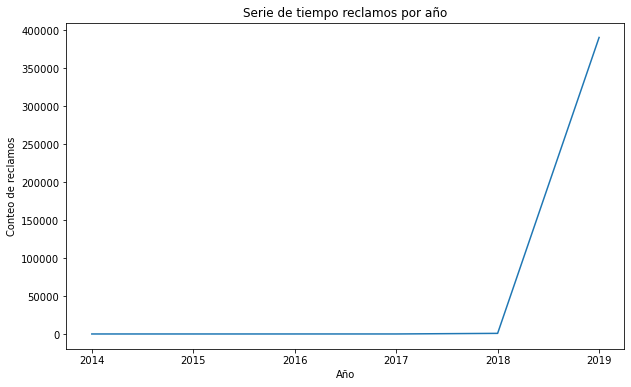

In [25]:

movie_year = pd.DataFrame(Seguro_salud['Fecha_Reclamacion'].groupby(Seguro_salud['Año']).count())
movie_year.reset_index(inplace=True)
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(movie_year['Año'], movie_year['Fecha_Reclamacion'])

ax.set_xlabel('Año')
ax.set_ylabel('Conteo de reclamos')
ax.set_title('Serie de tiempo reclamos por año')
plt.show()

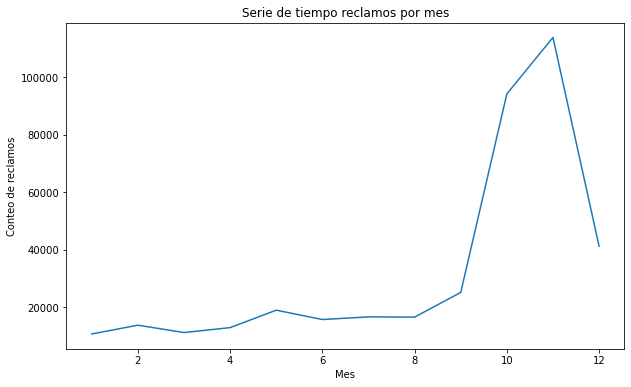

In [26]:
movie_year = pd.DataFrame(Seguro_salud['Fecha_Reclamacion'].groupby(Seguro_salud['Mes']).count())
movie_year.reset_index(inplace=True)

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(movie_year['Mes'], movie_year['Fecha_Reclamacion'])

ax.set_xlabel('Mes')
ax.set_ylabel('Conteo de reclamos')
ax.set_title('Serie de tiempo reclamos por mes')
plt.show()

In [27]:
Seguro=Seguro_salud.groupby(["CANCER"])["Precio"].sum().reset_index()
Seguro=pd.DataFrame(Seguro)
Seguro["CANCER"]=Seguro["CANCER"].replace(0.0,"CANCER[0]")
Seguro["CANCER"]=Seguro["CANCER"].replace(1.0,"CANCER[1]")
Seguro=Seguro.rename(columns={"CANCER":"ENFERMEDAD"})
Seguro



,ENFERMEDAD,Precio
0,CANCER[0],9.729618e+10
1,CANCER[1],1.498876e+10


In [28]:
Seguro1=Seguro_salud.groupby(["EPOC"])["Precio"].sum().reset_index()
Seguro1=pd.DataFrame(Seguro1)
Seguro1["EPOC"]=Seguro1["EPOC"].replace(0.0,"Epoc[0]")
Seguro1["EPOC"]=Seguro1["EPOC"].replace(1.0,"Epoc[1]")
Seguro1=Seguro1.rename(columns={"EPOC":"ENFERMEDAD"})
Seguro1

,ENFERMEDAD,Precio
0,Epoc[0],1.098800e+11
1,Epoc[1],2.404939e+09


In [29]:
Seguro2=Seguro_salud.groupby(["DIABETES"])["Precio"].sum().reset_index()
Seguro2=pd.DataFrame(Seguro2)
Seguro2["DIABETES"]=Seguro2["DIABETES"].replace(0.0,"Diabetes[0]")
Seguro2["DIABETES"]=Seguro2["DIABETES"].replace(1.0,"Diabetes[1]")
Seguro2=Seguro2.rename(columns={"DIABETES":"ENFERMEDAD"})
Seguro2

,ENFERMEDAD,Precio
0,Diabetes[0],1.063084e+11
1,Diabetes[1],5.976564e+09


In [30]:
Seguro3=Seguro_salud.groupby(["HIPERTENSION"])["Precio"].sum().reset_index()
Seguro3=pd.DataFrame(Seguro3)
Seguro3["HIPERTENSION"]=Seguro3["HIPERTENSION"].replace(0.0,"HIPERTENSION[0]")
Seguro3["HIPERTENSION"]=Seguro3["HIPERTENSION"].replace(1.0,"HIPERTENSION[1]")
Seguro3=Seguro3.rename(columns={"HIPERTENSION":"ENFERMEDAD"})
Seguro3

,ENFERMEDAD,Precio
0,HIPERTENSION[0],9.335884e+10
1,HIPERTENSION[1],1.892610e+10


In [31]:
Seguro4=Seguro_salud.groupby(["ENF_CARDIOVASCULAR"])["Precio"].sum().reset_index()
Seguro4=pd.DataFrame(Seguro4)
Seguro4["ENF_CARDIOVASCULAR"]=Seguro4["ENF_CARDIOVASCULAR"].replace(0.0,"ENF_CARDIOVASCULAR[0]")
Seguro4["ENF_CARDIOVASCULAR"]=Seguro4["ENF_CARDIOVASCULAR"].replace(1.0,"ENF_CARDIOVASCULAR[1]")
Seguro4=Seguro4.rename(columns={"ENF_CARDIOVASCULAR":"ENFERMEDAD"})
Seguro4

,ENFERMEDAD,Precio
0,ENF_CARDIOVASCULAR[0],1.098745e+11
1,ENF_CARDIOVASCULAR[1],2.410410e+09


In [32]:
Enfermedades1=pd.concat([Seguro, Seguro1, Seguro2, Seguro3, Seguro4], axis=0,).reset_index()
Enfermedades1

,index,ENFERMEDAD,Precio
0,0,CANCER[0],9.729618e+10
1,1,CANCER[1],1.498876e+10
2,0,Epoc[0],1.098800e+11
3,1,Epoc[1],2.404939e+09
4,0,Diabetes[0],1.063084e+11
5,1,Diabetes[1],5.976564e+09
6,0,HIPERTENSION[0],9.335884e+10
7,1,HIPERTENSION[1],1.892610e+10
8,0,ENF_CARDIOVASCULAR[0],1.098745e+11
9,1,ENF_CARDIOVASCULAR[1],2.410410e+09


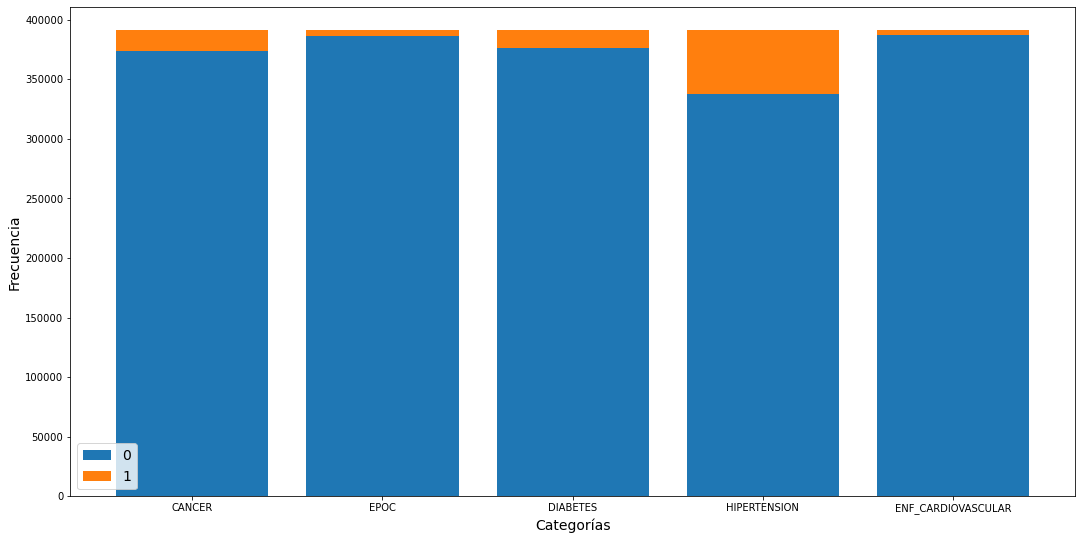

In [33]:

categoricas = Seguro_salud.loc[:, ["CANCER", "EPOC", "DIABETES", "HIPERTENSION", "ENF_CARDIOVASCULAR"]]
df = pd.DataFrame(categoricas)


zeros = [len(df[df[col] == 0]) for col in df.columns]
ones = [len(df[df[col] == 1]) for col in df.columns]

fig, ax = plt.subplots(figsize=(18, 9))

ax.bar(df.columns, zeros, label='0')
ax.bar(df.columns, ones, bottom=zeros, label='1')


ax.set_xticks(range(len(df.columns)))
ax.set_xticklabels(df.columns)
ax.set_xlabel('Categorías', fontsize=14)
ax.set_ylabel('Frecuencia', fontsize=14)
ax.legend(fontsize=14)

plt.show()

In [34]:
base = Enfermedades1.groupby(['ENFERMEDAD'])[['Precio']].sum().sort_values('Precio', ascending = True).reset_index().head(5)

# Gráfica
fig = px.pie(base, values = 'Precio', names ='ENFERMEDAD',
             title= '<b>Relación de costo en función de las enfermedades<b>',
             color_discrete_sequence=px.colors.qualitative.G10)

# # Agrear etiquetas a las porciones
fig.update_layout(
    template = 'simple_white',
    title_x = 0.5)

fig.show()

## ALGORITMOS SELECCIONADOS

In [35]:
Seguro_salud=Seguro_salud.loc[Seguro_salud["Año"]== 2019]
Seguro_salud=Seguro_salud.loc[Seguro_salud["Mes"] >= 9]
Seguro_salud

,Fecha_Reclamacion,Afiliado_Id,Reclamacion_codigo,Diagnostico_Codigo,Cantidad,Precio,Sexo_codigo,Edad,Regional_codigo,CANCER,EPOC,DIABETES,HIPERTENSION,ENF_CARDIOVASCULAR,Regional_Desc,Diagnostico_Desc,Reclamacion_Desc,Año,Mes
0,2019-10-23,22914637,12,M45X,1.0,1056639.96,M,28.0,5,0.0,0.0,0.0,0.0,0.0,REGIONAL EJE CAFETERO,ESPONDILITIS ANQUILOSANTE,EXAMENES DE DIAGNOSTICO,2019,10
1,2019-11-26,58412744,9,0,1.0,139772.80,F,15.0,2,0.0,0.0,0.0,0.0,0.0,REGIONAL CENTRO,DIAGNÓSTICO PENDIENTE,CONSULTA EXTERNA,2019,11
2,2019-10-23,5070923,16,0,1.0,320166.76,F,45.0,2,0.0,0.0,0.0,0.0,0.0,REGIONAL CENTRO,DIAGNÓSTICO PENDIENTE,LABORATORIO CLINICO,2019,10
3,2019-11-27,5769950,13,0,1.0,21204.00,F,91.0,2,0.0,0.0,0.0,0.0,0.0,REGIONAL CENTRO,DIAGNÓSTICO PENDIENTE,FISIOTERAPIA ILIMITADA,2019,11
5,2019-11-30,17126150,16,0,1.0,160700.28,M,38.0,1,0.0,0.0,0.0,1.0,0.0,REGIONAL ANTIOQUIA,DIAGNÓSTICO PENDIENTE,LABORATORIO CLINICO,2019,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395862,2019-11-20,15648118,13,0,1.0,21204.00,M,35.0,2,0.0,0.0,0.0,0.0,0.0,REGIONAL CENTRO,DIAGNÓSTICO PENDIENTE,FISIOTERAPIA ILIMITADA,2019,11
395863,2019-11-14,4351189,16,0,15.0,251820.44,F,68.0,5,0.0,0.0,0.0,1.0,0.0,REGIONAL EJE CAFETERO,DIAGNÓSTICO PENDIENTE,LABORATORIO CLINICO,2019,11
395865,2019-10-25,19220270,13,0,10.0,475726.00,F,39.0,1,0.0,0.0,0.0,0.0,0.0,REGIONAL ANTIOQUIA,DIAGNÓSTICO PENDIENTE,FISIOTERAPIA ILIMITADA,2019,10
395866,2019-11-12,25627716,12,0,2.0,568788.00,F,38.0,2,0.0,0.0,0.0,0.0,0.0,REGIONAL CENTRO,DIAGNÓSTICO PENDIENTE,EXAMENES DE DIAGNOSTICO,2019,11


In [36]:
todrop=['Afiliado_Id','Fecha_Reclamacion','Regional_Desc', 'Diagnostico_Desc',
       'Reclamacion_Desc',"Año","Mes"]

In [37]:
Seguro_predictivo=Seguro_salud.drop(columns=todrop)
Seguro_predictivo

,Reclamacion_codigo,Diagnostico_Codigo,Cantidad,Precio,Sexo_codigo,Edad,Regional_codigo,CANCER,EPOC,DIABETES,HIPERTENSION,ENF_CARDIOVASCULAR
0,12,M45X,1.0,1056639.96,M,28.0,5,0.0,0.0,0.0,0.0,0.0
1,9,0,1.0,139772.80,F,15.0,2,0.0,0.0,0.0,0.0,0.0
2,16,0,1.0,320166.76,F,45.0,2,0.0,0.0,0.0,0.0,0.0
3,13,0,1.0,21204.00,F,91.0,2,0.0,0.0,0.0,0.0,0.0
5,16,0,1.0,160700.28,M,38.0,1,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
395862,13,0,1.0,21204.00,M,35.0,2,0.0,0.0,0.0,0.0,0.0
395863,16,0,15.0,251820.44,F,68.0,5,0.0,0.0,0.0,1.0,0.0
395865,13,0,10.0,475726.00,F,39.0,1,0.0,0.0,0.0,0.0,0.0
395866,12,0,2.0,568788.00,F,38.0,2,0.0,0.0,0.0,0.0,0.0


In [38]:
Seguro_predictivo.to_csv("Preprocesamiento_Finanzas1.csv")